# Breast cancer data analysis - v1
- https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

# Credit:
- http://rasbt.github.io/mlxtend/

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve, validation_curve, KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from xgboost.sklearn import XGBRegressor
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_decision_regions, plot_learning_curves, plot_confusion_matrix
from math import sqrt
from scipy import stats
import datetime
import sys
from inspect import getsourcefile
import os.path
import re
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# Input data files are available in the DATA_DIR directory.
DATA_DIR = "data-temp"

# Load data

In [2]:
# Load data. Download from:https://www.kaggle.com/sarahvch/breast-cancer-wisconsin-prognostic-data-set
train_data = pd.read_csv(DATA_DIR + "/data.csv")

In [3]:
train_data = train_data.iloc[:, :-1]
train_data.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Encode label value

In [4]:
label = 'diagnosis'
target = train_data[label]
target.head(5)

0    M
1    M
2    M
3    M
4    M
Name: diagnosis, dtype: object

In [5]:
data_dict = {'M':1, 'B':0}
target = target.map(data_dict)
target[:5]


0    1
1    1
2    1
3    1
4    1
Name: diagnosis, dtype: int64

In [6]:
train_set = train_data.drop(['id', label], axis=1)
train_set[:5]

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Exploring data

### Check null data

In [7]:
def check_null_data(data):
    #Get high percent of NaN data
    null_data = data.isnull()
    total = null_data.sum().sort_values(ascending=False)
    percent = (null_data.sum()/null_data.count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    high_percent_miss_data = missing_data[missing_data['Percent']>0]
    #print(missing_data)
    print(high_percent_miss_data)
    miss_data_cols = high_percent_miss_data.index.values
    return miss_data_cols

In [8]:
check_null_data(train_data)

Empty DataFrame
Columns: [Total, Percent]
Index: []


array([], dtype=object)

In [9]:
train_set.dtypes

radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst       float64
symmetry_worst      

# Train model

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(train_set, target, train_size=0.7, random_state=324)
print("train size:", X_train.shape, " test size:", X_test.shape)

train size: (398, 30)  test size: (171, 30)


In [121]:
model = LogisticRegression()
#model = SVC()
#model = DecisionTreeClassifier()
model.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [102]:
y_pred = model.predict(X_test)
print(model.score(X_test, Y_test))

0.93567251462


### Plot decision boundary

In [57]:
def get_column_index(data, column_name):
    return data.columns.get_loc(column_name)

In [119]:
x_label = 'perimeter_mean'
y_label = 'compactness_worst'
data = X_train
x_data = data[x_label]
y_data = data[y_label]
feature_index =(get_column_index(data, x_label), get_column_index(data, y_label))
print('feature_index:', feature_index)
X = data.values
y = Y_train.values
cols = data.columns.values
cols = np.setdiff1d(cols, [x_label, y_label])
row = data[cols][1:2]
#print(row)
X_dict = row.to_dict(orient='records')[0]
filler_feature_values = {}
for key in X_dict:
    filler_feature_values[get_column_index(data, key)] = X_dict[key]
#filler_feature_values 
    

feature_index: (2, 25)


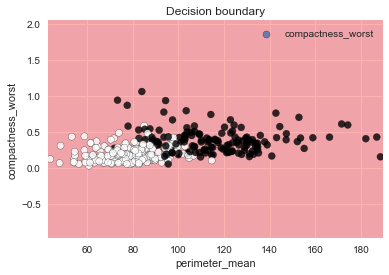

In [123]:
# Plotting decision regions
fig, ax = plt.subplots()
plot_decision_regions(X, y, clf=model,
                      feature_index = feature_index,
                      filler_feature_values=filler_feature_values,
                      res=0.02, legend=2, ax=ax,
                      
                     )
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title('Decision boundary')
ax.scatter(x=x_data,
           y=y_data,
           alpha=0.8,
           c=y,
           edgecolor='black')
plt.legend()
plt.show()

### Plot learning curve

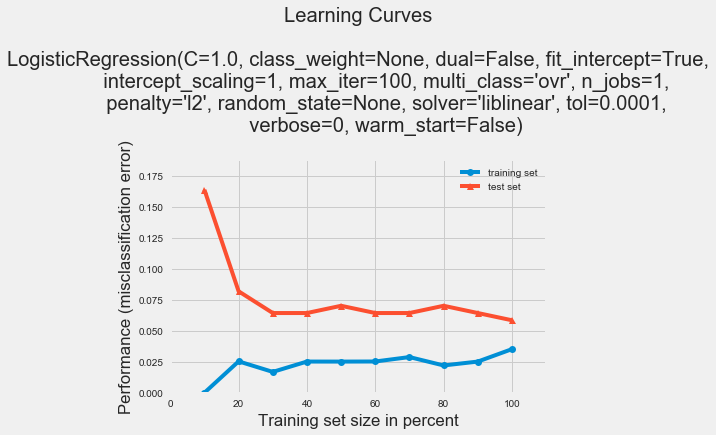

In [124]:
plot_learning_curves(X_train, Y_train, X_test, Y_test, model)
plt.show()

### Plot Confusion matrix

(<matplotlib.figure.Figure at 0x7f9b2cb83240>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9b2b69b278>)

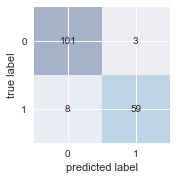

In [128]:
cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=y_pred)
plot_confusion_matrix(conf_mat=cm)